# Object Motion Model Estimator
References:
- https://en.wikipedia.org/wiki/Equations_of_motion#Constant_linear_acceleration_in_any_direction

## Helper functions
Since we are dealing here with position and therefore path prediction, it would be good if we could visualize the object and predicted path in a X-Y plane, with arrows connecting the points.

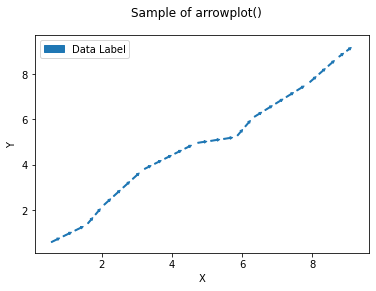

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# preallocate empty array and assign slice by chrisaycock
def shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result


def arrowplot(axes, x, y, nArrs=30, mutateSize=10, markerStyle='o', label=""): 
    '''arrowplot : plots arrows along a path on a set of axes
        axes   :  the axes the path will be plotted on
        x      :  list of x coordinates of points defining path
        y      :  list of y coordinates of points defining path
        nArrs  :  Number of arrows that will be drawn along the path
        mutateSize :  Size parameter for arrows
        color  :  color of the edge and face of the arrow head
        markerStyle : Symbol
    
        Bugs: If a path is straight vertical, the matplotlab FanceArrowPatch bombs out.
          My kludge is to test for a vertical path, and perturb the second x value
          by 0.1 pixel. The original x & y arrays are not changed
    
        MHuster 2016, based on code by
        refs: https://stackoverflow.com/a/39782685/3850957
    '''
    # recast the data into numpy arrays
    x = np.array(x, dtype='f')
    y = np.array(y, dtype='f')
    nPts = len(x)

    # Plot the points first to set up the display coordinates
    ax = axes.plot(x,y, markerStyle, ms=5, alpha=0)
    color = ax[-1].get_color()

    # get inverse coord transform
    inv = axes.transData.inverted()

    # transform x & y into display coordinates
    # Variable with a 'D' at the end are in display coordinates
    xyDisp = np.array(axes.transData.transform(list(zip(x,y))))
    xD = xyDisp[:,0]
    yD = xyDisp[:,1]

    # drD is the distance spanned between pairs of points
    # in display coordinates
    dxD = xD[1:] - xD[:-1]
    dyD = yD[1:] - yD[:-1]
    drD = np.sqrt(dxD**2 + dyD**2)

    # Compensating for matplotlib bug
    dxD[np.where(dxD==0.0)] = 0.1

    # rtotS is the total path length
    rtotD = np.sum(drD)

    # based on nArrs, set the nominal arrow spacing
    arrSpaceD = rtotD / nArrs

    # Loop over the path segments
    iSeg = 0
    while iSeg < nPts - 1:
        # Figure out how many arrows in this segment.
        # Plot at least one.
        nArrSeg = max(1, int(drD[iSeg] / arrSpaceD + 0.5))
        xArr = -mutateSize +dxD[iSeg] / nArrSeg  # x size of each arrow
        segSlope = dyD[iSeg] / dxD[iSeg]
        # Get display coordinates of first arrow in segment
        xBeg = xD[iSeg] - mutateSize/2
        xEnd = xBeg + xArr
        yBeg = yD[iSeg] - mutateSize/2
        yEnd = yBeg + segSlope * xArr
        # Now loop over the arrows in this segment
        for iArr in range(nArrSeg):
            # Transform the oints back to data coordinates
            xyData = inv.transform(((xBeg, yBeg),(xEnd,yEnd)))
            # Use a patch to draw the arrow
            # I draw the arrows with an alpha of 0.5
            p = patches.FancyArrowPatch(
                xyData[0], xyData[1],
                arrowstyle='simple',
                mutation_scale=mutateSize,
                color=color,
            )
            axes.add_patch(p)
            # Increment to the next arrow
            xBeg = xEnd
            xEnd += xArr
            yBeg = yEnd
            yEnd += segSlope * xArr
        # Increment segment number
        iSeg += 1

    axes.patches[-1].set_label(label)


# my random data
np.random.seed(101)
x = np.random.random(10) + np.arange(10)
y = np.random.random(10) + np.arange(10)

# plot
fig = plt.figure()
plt.suptitle("Sample of arrowplot()")
axes = fig.add_subplot(111)
axes.set_xlabel("X")
axes.set_ylabel("Y")
arrowplot(axes, x, y, nArrs=30, mutateSize=5, label="Data Label")
axes.legend()
plt.show()

## Building the model for object and its movement

In [2]:
import numpy as np


class ObjectModel:
    def __init__(self, position):
        self.positions = np.array([position, (0,0)], dtype=tuple)
        self.speeds = np.array([(0,0), (0,0)], dtype=tuple)
        self.accels = np.array([(0,0), (0,0)], dtype=tuple)

    def diff(self, var: type(np.array([(0,0), (0,0)], dtype=tuple))) -> tuple:
        return (var[1][0] - var[0][0], var[1][1] - var[0][1])
        
    def update(self, position: tuple) -> tuple:
        self.positions[1] = self.positions[0]
        self.positions[0] = position
        
        self.speeds[1] = self.speeds[0]
        self.speeds[0] = self.diff(self.positions)
        
        self.accels[1] = self.accels[0]
        self.accels[0] = self.diff(self.speeds)
        
        return (
            np.array(self.positions[0], dtype=float),
            np.array(self.speeds[0], dtype=float),
            np.array(self.accels[0], dtype=float)
        )

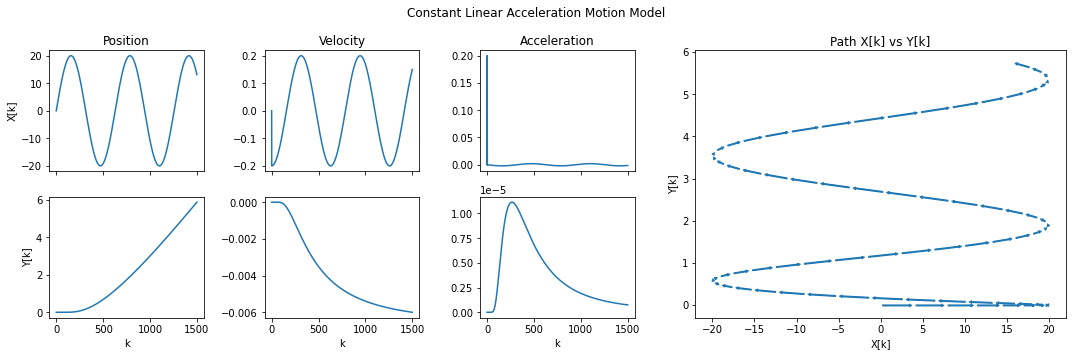

In [3]:
import matplotlib.pyplot as plt


# Dataset definition
k_max = 1500
vk = np.arange(k_max, dtype=int)
train_x = 20 * np.sin(vk*0.01)
train_y = 20 * (((vk/k_max) * np.exp(-800 / (vk+4)))/2)
train_x_noisy = train_x + 2*np.random.random(len(vk))
train_y_noisy = train_y + np.random.random(len(vk))/2

# Model Simulation
obj_position = np.zeros((k_max, 2), dtype=float)
obj_position_noisy = np.zeros((k_max, 2), dtype=float)
obj_speed = np.zeros((k_max, 2), dtype=float)
obj_accel = np.zeros((k_max, 2), dtype=float)
obj = ObjectModel((0,0))
obj_noisy = ObjectModel((0,0))
for k in vk:
    obj_position[k], obj_speed[k], obj_accel[k] = obj.update((train_x[k], train_y[k]))
    obj_position_noisy[k], _, _ = obj_noisy.update((train_x_noisy[k], train_y_noisy[k]))
    
fig, axs = plt.subplots(figsize=(15,5), nrows=2, ncols=5, sharex=True)
plt.suptitle("Constant Linear Acceleration Motion Model")

axs[0,0].set_title("Position")
axs[0,0].set_ylabel("X[k]")
axs[0,0].plot(vk, obj_position[:,0], label="Position X")
axs[1,0].set_xlabel("k")
axs[1,0].set_ylabel("Y[k]")
axs[1,0].plot(vk, obj_position[:,1], label="Position Y")

axs[0,1].set_title("Velocity")
axs[0,1].plot(vk, obj_speed[:,0], label="Velocity X")
axs[1,1].set_xlabel("k")
axs[1,1].plot(vk, obj_speed[:,1], label="Velocity Y")

axs[0,2].set_title("Acceleration")
axs[0,2].plot(vk, obj_accel[:,0], label="Acceleration X")
axs[1,2].set_xlabel("k")
axs[1,2].plot(vk, obj_accel[:,1], label="Acceleration Y")

gs = axs[0, 3].get_gridspec()
for axx in axs[0:, 3:]:
    for ax in axx:
        ax.remove()
axbig = fig.add_subplot(gs[0:, 3:])
axbig.set_title("Path X[k] vs Y[k]")
axbig.set_xlabel("X[k]")
axbig.set_ylabel("Y[k]")
arrowplot(axbig, obj_position[::20,0], obj_position[::20,1], nArrs=30, mutateSize=5)

plt.tight_layout()
plt.show()

## Building the Estimator
The Constant Linear Acceleration Motion equation is:
$$ r_{k+1} = r_{k} + v_{k}\,k -\frac{1}{2}a_{k}\,k^2 $$

If we will be incrementing at a fixed rate with period $k$, then the motion can be described as:
$$ r_{k+1} = r_{k} + v_{k} -\frac{1}{2}a_{k} $$



In [4]:
class ConstantLinearAccelerationEstimator:
    def __init__(self, predict_samples, coeffs, use_averages=False):
        self.errors = np.array([(0,0)]*len(coeffs), dtype=float)
        self.obs = ObjectModel((0,0))
        self.predict_samples = predict_samples
        self.action = 0
        self.coeffs = np.array(list(coeffs), dtype=float)
        self.use_averages = use_averages

    def _compute_position(self, r0, v, a, dk):
        r = r0 + (v * dk) - 0.5 * (a * dk**2)
        return r
        
    def _predict(self) -> np.array:
        predictions = np.empty(shape=(self.predict_samples, 2), dtype=float)

        for k in range(self.predict_samples):
            if self.use_averages == True:
                v = self.obs.speeds.mean(axis=0)
                a = self.obs.accels.mean(axis=0)
            else:
                v = self.obs.speeds[0]
                a = self.obs.accels[0]
            r = self.obs.positions[0]

            # FIR Controller/Observer
            action = np.array([0,0], dtype=float)
            for i in range(len(self.coeffs)):
                action += self.coeffs[i] * self.errors[i]
            self.action += action
            self.obs.update(self.action)
        
            r = self._compute_position(r, v, a, dk=1)
            self.obs.positions[0] = r
            
            predictions[k] = self.obs.positions[0]
            
        return predictions
    
    def sample(self, position) -> np.array:
        self.errors = shift(self.errors, 1)
        self.errors[0] = position - self.obs.positions[0]
        
        return self._predict()


hat_position = np.zeros((k_max, 2), dtype=float)
samples = 50
coeffs = np.array([-2], dtype=float) / samples
hat_obj = ConstantLinearAccelerationEstimator(samples, coeffs, False)
for k in vk:
    if k % samples == 0:
        hat_position[k:k+samples] = hat_obj.sample(obj_position[k])

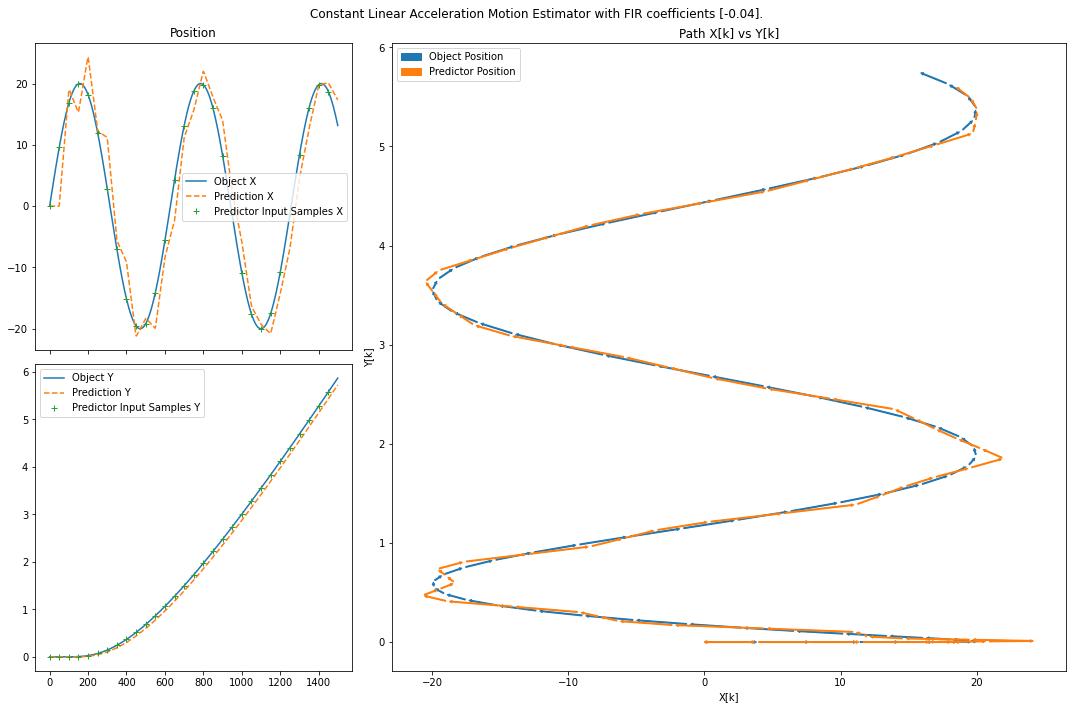

In [5]:
fig, axs = plt.subplots(figsize=(15,10), nrows=2, ncols=3, sharex=True)

plt.suptitle(f"Constant Linear Acceleration Motion Estimator with FIR coefficients {coeffs}.")
axs[0,0].set_title("Position")
axs[0,0].plot(vk, obj_position[:,0], label="Object X")
axs[0,0].plot(vk, hat_position[:,0], '--', label="Prediction X")
axs[0,0].plot(vk[::samples], obj_position[::samples,0], marker='+', linestyle="None", label="Predictor Input Samples X")
axs[0,0].legend()

axs[1,0].plot(vk, obj_position[:,1], label="Object Y")
axs[1,0].plot(vk, hat_position[:,1], '--', label="Prediction Y")
axs[1,0].plot(vk[::samples], obj_position[::samples,1], marker='+', linestyle="None", label="Predictor Input Samples Y")
axs[1,0].legend()

gs = axs[0, 1].get_gridspec()
for axx in axs[0:, 1:]:
    for ax in axx:
        ax.remove()
axbig = fig.add_subplot(gs[0:, 1:])
axbig.set_title("Path X[k] vs Y[k]")
axbig.set_xlabel("X[k]")
axbig.set_ylabel("Y[k]")
arrowplot(axbig, obj_position[::20,0], obj_position[::20,1], nArrs=30, mutateSize=5, label="Object Position")
arrowplot(axbig, hat_position[::20,0], hat_position[::20,1], nArrs=30, mutateSize=5, label="Predictor Position")
axbig.legend()

plt.tight_layout()
plt.show()

## Optimizing FIR coefficients to enhance the estimator precision

In [6]:
import lmfit


def model(input: np.array, coeffs: np.array, samples: int, use_averages: bool) -> np.array:
    samples = int(samples)
    estimator = ConstantLinearAccelerationEstimator(samples, coeffs, use_averages)
    output = np.zeros((k_max, 2), dtype=float)
    for k in np.arange(len(input), dtype=int):
        if k % samples == 0:
            output[k:k+samples] = estimator.sample(input[k])
    return output


def resid(params, input):
    # Get the Parameters
    samples = int(params['samples'].value)
    use_averages = bool(params['use_averages'].value)
    a = params['a'].value
    b = params['b'].value
    coeffs = np.array([a, b], dtype=float)
        
    # Run the Model
    output = model(input, coeffs, samples, use_averages)
    
    # Compute residuals
    return output - input


use_averages = False
params = lmfit.Parameters()
params.add('a', min=-3, max=3, vary=True)
params.add('b', min=-3, max=3, vary=True)
params.add('samples', value=50, min=1, max=100, vary=False)
params.add('use_averages', value=use_averages, vary=False)
# params.add('constraints', expr="a!=0 and b!=0")

# https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.minimize
result = lmfit.minimize(
    resid,
    params,
    args=tuple([obj_position]),
    nan_policy='raise',
#     reduce_fcn='negentropy',
    method='differential_evolution',  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
    strategy='rand1bin',
#     max_nfev=8,
    init='random',
    popsize=4,
    workers=4,
    updating='deferred',
    seed=1,
    disp=True
)

use_averages = result.params['use_averages'].value
opt_coeffs = []
for var in result.var_names:
    opt_coeffs += [result.params[var].value]
opt_coeffs = np.array(opt_coeffs, dtype=float)
print("Optimal FIR coeffs:", opt_coeffs)

opt_positions = model(obj_position, opt_coeffs, samples=50, use_averages=use_averages)

result

differential_evolution step 1: f(x)= 5.71017e+94
differential_evolution step 2: f(x)= 1.88795e+66
differential_evolution step 3: f(x)= 1.88795e+66
differential_evolution step 4: f(x)= 4.75506e+61
differential_evolution step 5: f(x)= 4.75506e+61
differential_evolution step 6: f(x)= 4.75506e+61
differential_evolution step 7: f(x)= 2.47195e+51
differential_evolution step 8: f(x)= 2.47195e+51
differential_evolution step 9: f(x)= 1.55978e+38
differential_evolution step 10: f(x)= 1.55978e+38
differential_evolution step 11: f(x)= 1.14559e+24
differential_evolution step 12: f(x)= 1.14559e+24
differential_evolution step 13: f(x)= 1.14559e+24
differential_evolution step 14: f(x)= 2.68572e+18
differential_evolution step 15: f(x)= 2.68572e+18
differential_evolution step 16: f(x)= 317087
differential_evolution step 17: f(x)= 317087
differential_evolution step 18: f(x)= 317087
differential_evolution step 19: f(x)= 317087
differential_evolution step 20: f(x)= 317087
differential_evolution step 21: f(

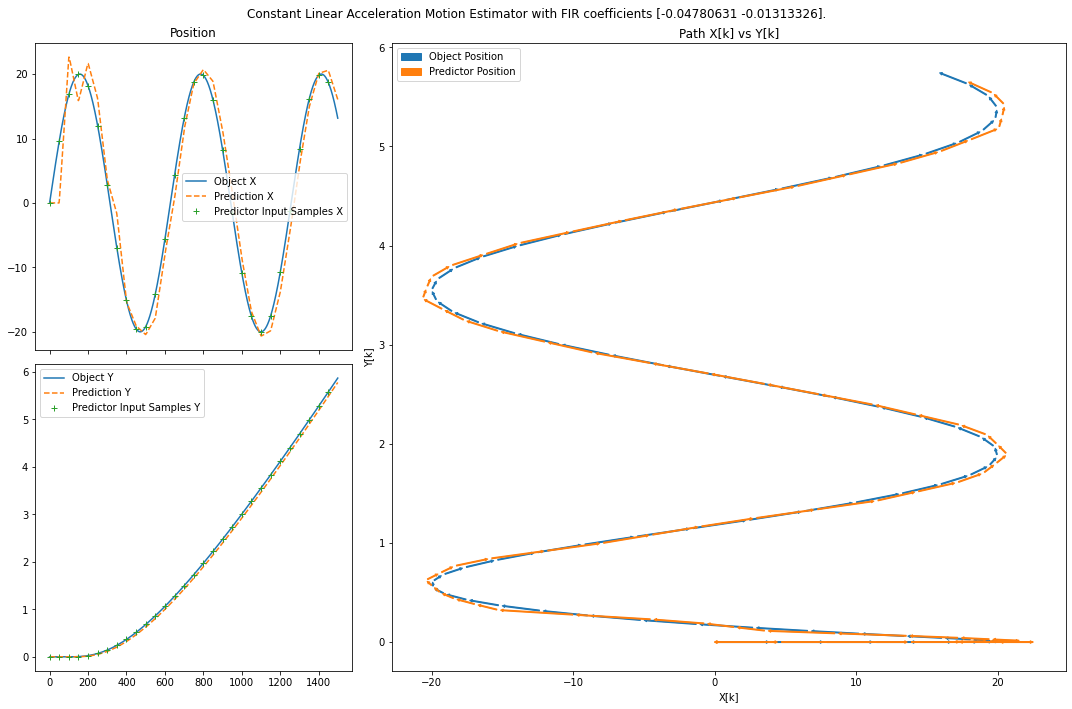

In [7]:
fig, axs = plt.subplots(figsize=(15,10), nrows=2, ncols=3, sharex=True)

plt.suptitle(f"Constant Linear Acceleration Motion Estimator with FIR coefficients {opt_coeffs}.")
axs[0,0].set_title("Position")
axs[0,0].plot(vk, obj_position[:,0], label="Object X")
axs[0,0].plot(vk, opt_positions[:,0], '--', label="Prediction X")
axs[0,0].plot(vk[::samples], obj_position[::samples,0], marker='+', linestyle="None", label="Predictor Input Samples X")
axs[0,0].legend()

axs[1,0].plot(vk, obj_position[:,1], label="Object Y")
axs[1,0].plot(vk, opt_positions[:,1], '--', label="Prediction Y")
axs[1,0].plot(vk[::samples], obj_position[::samples,1], marker='+', linestyle="None", label="Predictor Input Samples Y")
axs[1,0].legend()

gs = axs[0, 1].get_gridspec()
for axx in axs[0:, 1:]:
    for ax in axx:
        ax.remove()
axbig = fig.add_subplot(gs[0:, 1:])
axbig.set_title("Path X[k] vs Y[k]")
axbig.set_xlabel("X[k]")
axbig.set_ylabel("Y[k]")
arrowplot(axbig, obj_position[::20,0], obj_position[::20,1], nArrs=30, mutateSize=5, label="Object Position")
arrowplot(axbig, opt_positions[::20,0], opt_positions[::20,1], nArrs=30, mutateSize=5, label="Predictor Position")
axbig.legend()

plt.tight_layout()
plt.show()